<a href="https://colab.research.google.com/github/AaliyanShuja/SalesPrediction/blob/main/SalesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from   scipy.stats import f_oneway
from   scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from   statsmodels.stats.outliers_influence import variance_inflation_factor
from   statsmodels.stats.multicomp import pairwise_tukeyhsd
import lightgbm as lgb
from   prophet import Prophet
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import mean_squared_error, r2_score
from   sklearn.preprocessing import StandardScaler, MinMaxScaler
from   sklearn.linear_model import LinearRegression
from   datetime import datetime
import dask.dataframe as dd
from   google.colab import data_table
data_table.disable_dataframe_formatter()

In [ ]:
!pip install "dask[dataframe]"

In [ ]:
df = pd.read_csv('/content/Women_Ecommerce_Purchase_Data.csv')
df.head()

,order_id,order_date,sku,color,size,unit_price,quantity,revenue,age,discount,customer_rating,stock,category,category_id,category_avg_price,category_total_revenue,category_popularity,holiday_type
0,185,2022-08-11 21:03:00,799,Dark Blue,L,266,7,1862,59,20,3,276,Jeans,2,274,559255,83,No Holiday
1,13,2022-08-05 12:18:00,799,Dark Blue,L,266,7,1862,20,15,2,331,Jackets,1,273,633186,90,No Holiday
2,56,2022-09-12 20:19:00,799,Dark Blue,XL,275,10,2750,47,5,2,144,Dresses,0,273,563441,84,No Holiday
3,5,2022-06-11 14:46:00,799,Dark Blue,XL,264,7,1848,59,0,2,126,Jackets,1,273,633186,90,No Holiday
4,27,2022-08-08 19:18:00,799,Dark Blue,M,266,4,1064,63,0,3,496,Jeans,2,274,559255,83,No Holiday


In [ ]:
df.describe()

,order_id,unit_price,quantity,revenue,age,discount,customer_rating,stock,category_id,category_avg_price,category_total_revenue,category_popularity
count,2000.000000,2000.000000,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,114.659000,275.050000,5.480500,1508.5945,41.073000,10.382500,2.960500,273.291000,2.452000,274.823500,608832.895000,87.650000
std,75.079446,38.253983,2.904451,840.1872,13.834788,6.979653,1.369262,132.290516,1.891688,1.844464,61778.768256,7.138416
min,1.000000,191.000000,1.000000,191.0000,18.000000,0.000000,1.000000,50.000000,0.000000,273.000000,553327.000000,79.000000
25%,51.750000,266.000000,3.000000,807.0000,28.750000,5.000000,2.000000,152.000000,1.000000,273.000000,559255.000000,83.000000
50%,105.000000,278.000000,5.000000,1459.5000,41.000000,10.000000,3.000000,272.000000,2.000000,274.000000,563441.000000,84.000000
75%,166.000000,288.000000,8.000000,2152.0000,53.000000,15.000000,4.000000,392.000000,4.000000,277.000000,633186.000000,90.000000
max,273.000000,899.000000,10.000000,8990.0000,64.000000,20.000000,5.000000,498.000000,5.000000,277.000000,707980.000000,99.000000


In [ ]:
# Checking the missing values
print("Missing values per column:\n", df.isnull().sum())

# Filling the missing numeric columns with their median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing categorical columns with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('3XL')

Missing values per column:
 order_id                  0
order_date                0
sku                       0
color                     0
size                      0
unit_price                0
quantity                  0
revenue                   0
age                       0
discount                  0
customer_rating           0
stock                     0
category                  0
category_id               0
category_avg_price        0
category_total_revenue    0
category_popularity       0
holiday_type              0
dtype: int64


In [ ]:
# Removing the duplicates
df = df.drop_duplicates()
print(f"Shape after the duplicates removed is: {df.shape}")

Shape after the duplicates removed is: (1713, 18)


In [ ]:
# Defining the function to remove outliers based on IQR
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound  = Q1 - 1.5 * IQR
    upper_bound  = Q3 + 1.5 * IQR
    return dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]

# Apply the function to numeric columns
for col in numeric_cols:
    df = remove_outliers_iqr (df, col)

print(f"Shape after removing outliers: {df.shape}")


Shape after removing outliers: (1612, 18)


In [ ]:
cleaned_file_path = "/content/Women_Ecommerce_Purchase_Data.csv"
df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned data saved to {cleaned_file_path}")

Cleaned data saved to /content/Women_Ecommerce_Purchase_Data.csv


In [ ]:
print(df.describe())

# Values for the categoruical columns
print(df['color'].value_counts())
print(df['size'].value_counts())

          order_id   unit_price     quantity      revenue          age  \
count  1612.000000  1612.000000  1612.000000  1612.000000  1612.000000   
mean    118.169355   277.193548     5.461538  1514.750000    41.294665   
std      74.416609    15.571098     2.882191   806.087514    13.645349   
min       1.000000   238.000000     1.000000   238.000000    18.000000   
25%      54.000000   266.000000     3.000000   829.500000    29.000000   
50%     111.000000   278.000000     5.000000  1490.000000    41.000000   
75%     169.000000   288.000000     8.000000  2224.000000    53.000000   
max     273.000000   318.000000    10.000000  3180.000000    64.000000   

          discount  customer_rating        stock  category_id  \
count  1612.000000      1612.000000  1612.000000  1612.000000   
mean     10.272953         2.941067   273.093672     2.476427   
std       6.952883         1.369936   132.890337     1.895158   
min       0.000000         1.000000    50.000000     0.000000   
25%     

In [ ]:
 # Converting the  order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

 # Extracting the time-based features
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day_of_week'] = df['order_date'].dt.dayofweek
df['day'] = df['order_date'].dt.day

print(df.head())

   order_id          order_date  sku      color size  unit_price  quantity  \
0       185 2022-08-11 21:03:00  799  Dark Blue    L         266         7   
1        13 2022-08-05 12:18:00  799  Dark Blue    L         266         7   
2        56 2022-09-12 20:19:00  799  Dark Blue   XL         275        10   
3         5 2022-06-11 14:46:00  799  Dark Blue   XL         264         7   
4        27 2022-08-08 19:18:00  799  Dark Blue    M         266         4   

   revenue  age  discount  ...  category  category_id category_avg_price  \
0     1862   59        20  ...     Jeans            2                274   
1     1862   20        15  ...   Jackets            1                273   
2     2750   47         5  ...   Dresses            0                273   
3     1848   59         0  ...   Jackets            1                273   
4     1064   63         0  ...     Jeans            2                274   

   category_total_revenue  category_popularity  holiday_type  year month  

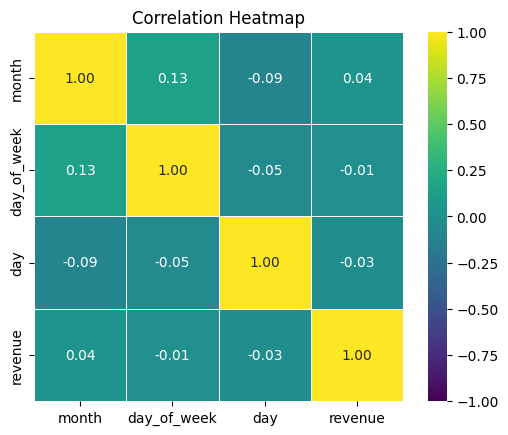

In [ ]:
correlation_matrix = df[['month', 'day_of_week','day', 'revenue']].corr()

#using heatmaps and finding correlation betweem different time with revenue
sns.heatmap(correlation_matrix, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
# Average revenue of month
monthly_revenue = df.groupby('month')['revenue'].mean()
print(monthly_revenue)

# Average revenue of week days
weekday_revenue = df.groupby('day_of_week')['revenue'].mean()
print(weekday_revenue)

# Average revenue of days
daily_revenue = df.groupby('day')['revenue'].mean()
print(daily_revenue)

month
6    1502.460714
7    1448.771341
8    1513.875764
9    1564.479532
Name: revenue, dtype: float64
day_of_week
0    1547.670175
1    1547.875706
2    1472.192661
3    1449.313953
4    1544.925651
5    1492.048193
6    1526.413223
Name: revenue, dtype: float64
day
1     1692.551724
2     1641.421053
3     1503.187500
4     1609.671875
5     1608.900000
6     1601.320000
7     1467.461538
8     1600.500000
9     1494.039604
10    1453.794872
11    1508.886364
12    1375.372093
13    1818.533333
14    1441.340909
15    1384.454545
16    1579.423077
17    1287.438596
18    1645.836066
19    1633.826087
20    1759.764706
21    1410.947368
22    1573.129032
23    1362.232558
24    1431.612245
25    1403.411765
26    1422.453333
27    1516.279070
28    1594.242424
29    1628.705882
30    1497.875000
31    1544.638889
Name: revenue, dtype: float64


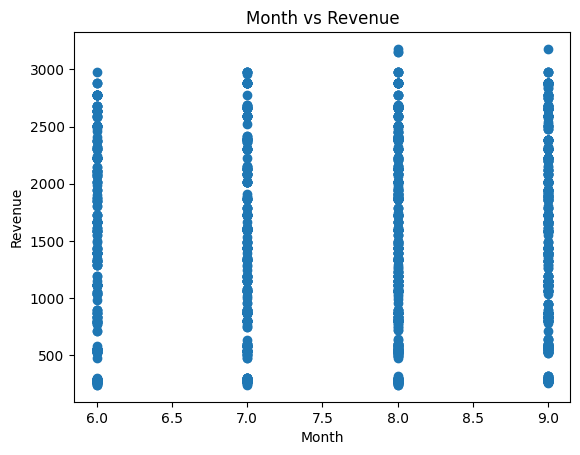

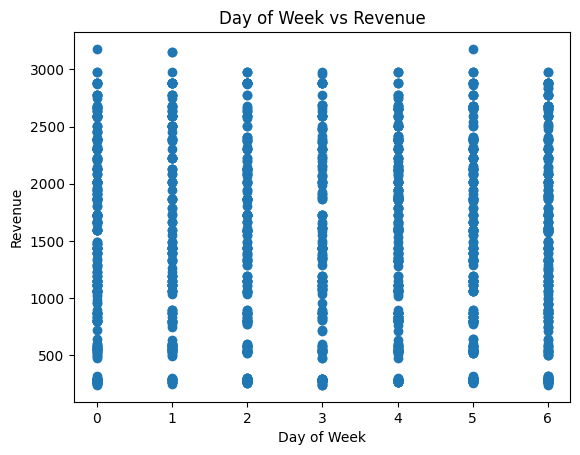

In [ ]:
# Scatter plot for month vs. revenue
plt.scatter(df['month'], df['revenue'])
plt.title('Month vs Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

# Scatter plot for day_of_week vs. revenue
plt.scatter(df['day_of_week'], df['revenue'])
plt.title('Day of Week vs Revenue')
plt.xlabel('Day of Week')
plt.ylabel('Revenue')
plt.show()

In [ ]:
# Add holiday flags (manually or using a calendar library)
df['is_holiday'] = df['order_date'].isin(['2024-12-25', '2024-11-23'])

# Analyze correlation with holidays
holiday_revenue = df.groupby('is_holiday')['revenue'].mean()
print(holiday_revenue)

is_holiday
False    1514.75
Name: revenue, dtype: float64


<ipython-input-18-54eaf9d3778a>:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['order_date'].isin(['2024-12-25', '2024-11-23'])


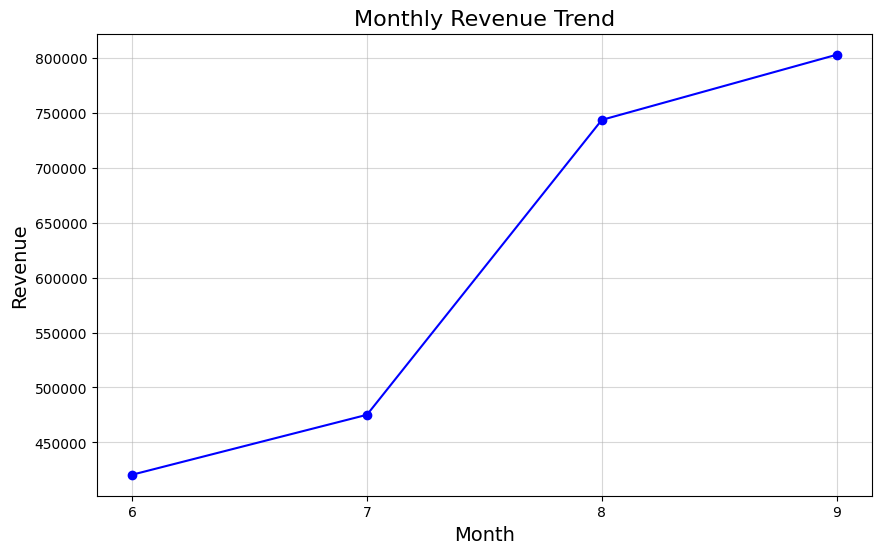

In [ ]:
# Extracting 'month' and 'revenue' for plotting
monthly_revenue = df.groupby('month')['revenue'].sum().reset_index()

# Plotting the line plot
plt.figure(figsize=(10, 6))
plt.plot ( monthly_revenue['month'],  monthly_revenue['revenue'], marker='o', linestyle='-', color='blue')
plt.title ('Monthly Revenue Trend', fontsize=16)
plt.xlabel ('Month', fontsize=14)
plt.ylabel ('Revenue', fontsize=14)
plt.xticks ( monthly_revenue['month'])  # Setting x-axis ticks to month values
plt.grid ( alpha=0.5 )
plt.show()

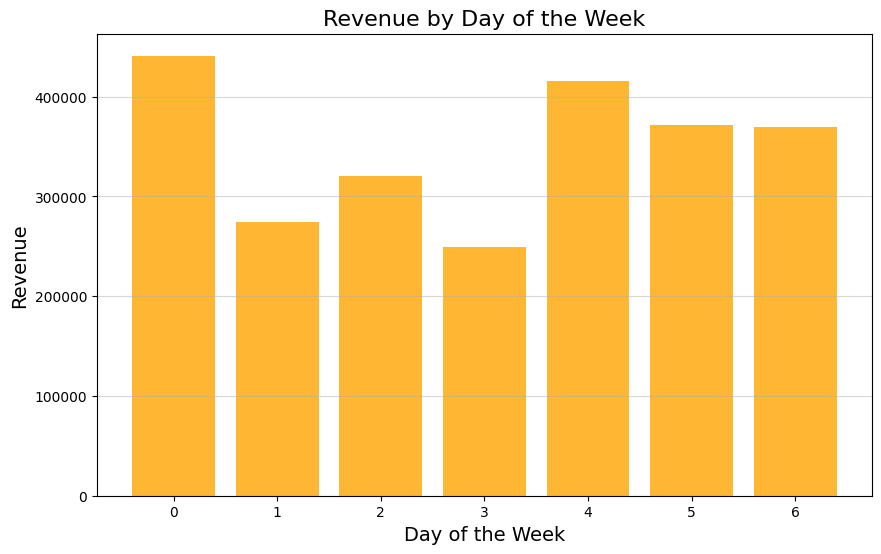

In [ ]:

# Taking the dataset for the datafrane 'df'
# Grouping revenue by the day of the week
day_of_week_revenue = df.groupby('day_of_week')['revenue'].sum().reset_index()

# Plotting the bar chart
plt.figure (figsize=(10, 6))
plt.bar (day_of_week_revenue['day_of_week'] , day_of_week_revenue['revenue'], color='orange', alpha=0.8)
plt.title ('Revenue by Day of the Week', fontsize=16)
plt.xlabel ('Day of the Week', fontsize=14)
plt.ylabel ('Revenue', fontsize=14)
plt.xticks (day_of_week_revenue['day_of_week'])  # Adjust tick labels
plt.grid ( axis='y', alpha=0.5 )
plt.show()

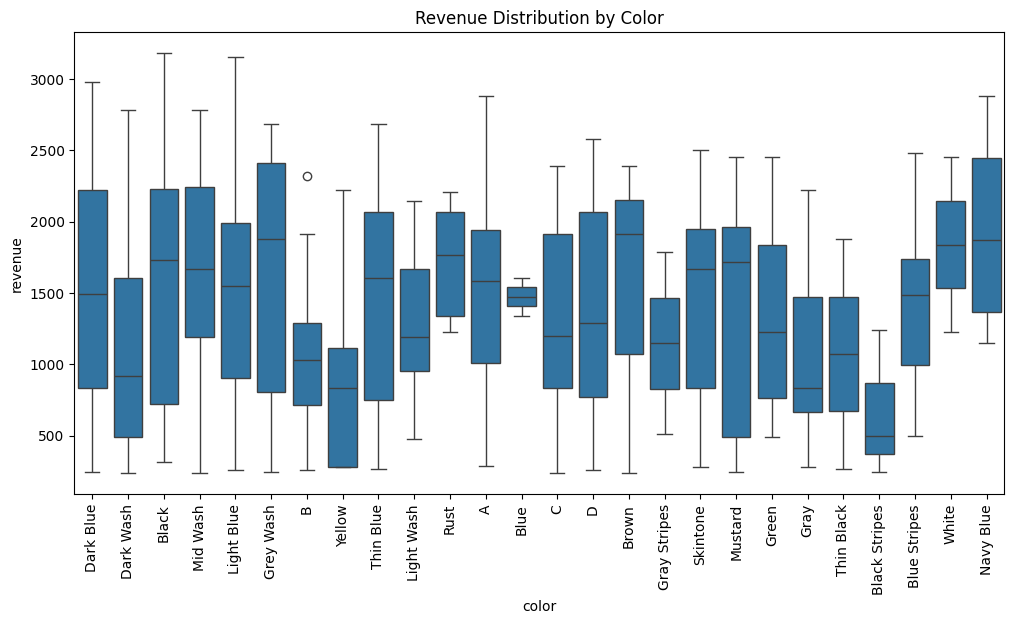

In [ ]:
# Box plot the distribution of revenue across different colors
plt.figure ( figsize=(12, 6))
sns.boxplot ( data=df, x='color', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ( 'Revenue Distribution by Color')
plt.show()

In [ ]:
color_revenue_avg = df.groupby('color')['revenue'].mean().reset_index()

# Displaying  the average revenue by color
print(color_revenue_avg)

            color      revenue
0               A  1497.600000
1               B  1107.230769
2           Black  1633.435897
3   Black Stripes   661.333333
4            Blue  1474.000000
5    Blue Stripes  1432.888889
6           Brown  1513.666667
7               C  1325.363636
8               D  1400.571429
9       Dark Blue  1527.800769
10      Dark Wash  1100.312500
11           Gray  1104.454545
12   Gray Stripes  1147.500000
13          Green  1337.714286
14      Grey Wash  1637.680000
15     Light Blue  1513.371429
16     Light Wash  1285.200000
17       Mid Wash  1660.680000
18        Mustard  1372.000000
19      Navy Blue  1944.000000
20           Rust  1719.666667
21       Skintone  1445.600000
22     Thin Black  1072.000000
23      Thin Blue  1517.666667
24          White  1837.500000
25         Yellow   945.200000


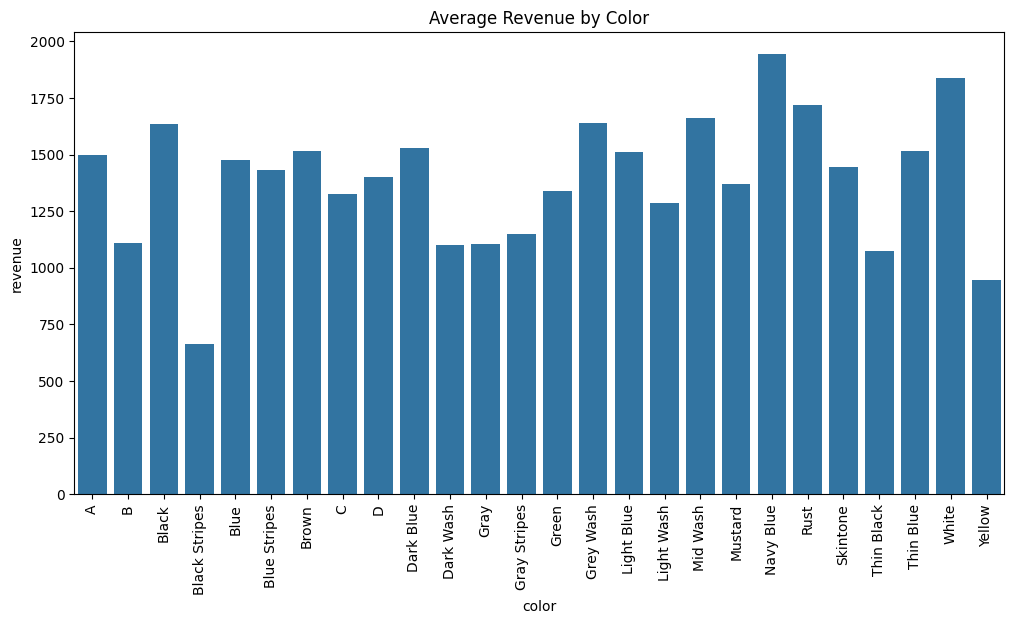

In [ ]:
# Using Bar plot for the average revenue by color
plt.figure (figsize=(12, 6))
sns.barplot ( data=color_revenue_avg, x='color', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ('Average Revenue by Color')
plt.show()

In [ ]:
from scipy.stats import f_oneway

# Performing the ANOVA to test if the revenue differs by color
colors = df['color'].unique()
grouped_revenue = [df[df['color'] == color]['revenue'] for color in colors]
anova_result = f_oneway(*grouped_revenue)

# Displaying the result of the ANOVA test
print ("ANOVA test result:", anova_result)

ANOVA test result: F_onewayResult(statistic=np.float64(1.0231995621290246), pvalue=np.float64(0.4314004700264416))


In [ ]:
# Perfoming it to get check the variance difference between revenue and color
model = smf.ols('revenue ~ C(color)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df['revenue'], groups=df['color'], alpha=0.05)
print(tukey)

                sum_sq      df       F  PR(>F)
C(color)  1.661531e+07    25.0  1.0232  0.4314
Residual  1.030176e+09  1586.0     NaN     NaN
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1        group2     meandiff p-adj    lower      upper   reject
------------------------------------------------------------------------
            A             B -390.3692    1.0  -1639.328  858.5895  False
            A         Black  135.8359    1.0  -916.6628 1188.3346  False
            A Black Stripes -836.2667 0.9984 -2790.9072 1118.3738  False
            A          Blue     -23.6    1.0 -2323.6192 2276.4192  False
            A  Blue Stripes  -64.7111    1.0 -1429.0159 1299.5936  False
            A         Brown   16.0667    1.0 -1938.5738 1970.7072  False
            A             C -172.2364    1.0 -1469.6222 1125.1495  False
            A             D  -97.0286    1.0 -1560.3215 1366.2644  False
            A     Dark Blue   30.2008    1.0  -912.3827 

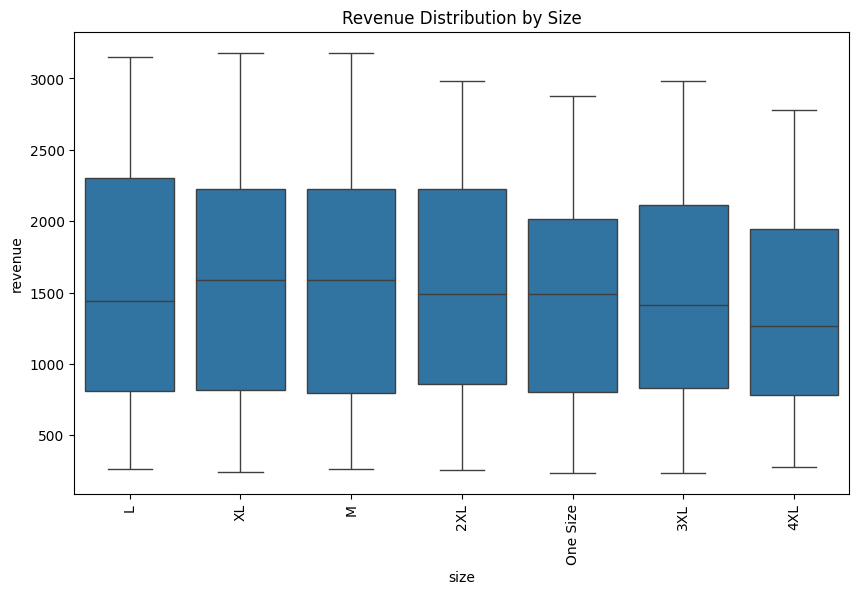

In [ ]:
# Box plot for visualizing the distribution of revenue across different sizes
plt.figure ( figsize=(10, 6))
sns.boxplot ( data=df, x='size', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ('Revenue Distribution by Size')
plt.show()

In [ ]:
# Calculating the average revenue per size
size_revenue_avg = df.groupby('size')['revenue'].mean().reset_index()

# Displaying the average revenue by size
print (size_revenue_avg)

       size      revenue
0       2XL  1548.507042
1       3XL  1482.313559
2       4XL  1320.187500
3         L  1524.781362
4         M  1534.643564
5  One Size  1469.405941
6        XL  1524.077071


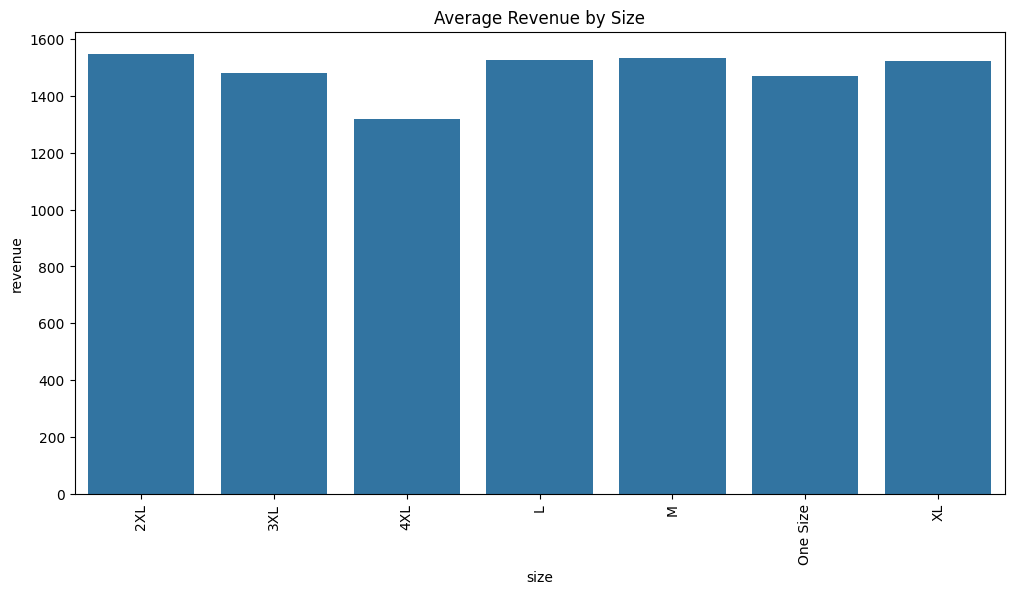

In [ ]:
# Bar plot for average revenue by size
plt.figure (figsize=(12, 6))
sns.barplot (data=size_revenue_avg, x='size', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ( 'Average Revenue by Size')
plt.show()

In [ ]:
# Performing the ANOVA to test if the revenue differs by size
sizes = df['size'].unique()
grouped_revenue = [df[df['size'] == size]['revenue'] for size in sizes]
anova_result = f_oneway(*grouped_revenue)

# Display the result of the ANOVA test
print("ANOVA test result:", anova_result)

ANOVA test result: F_onewayResult(statistic=np.float64(0.5177756933077345), pvalue=np.float64(0.795236457470134))


<ipython-input-32-0d141e04e4b7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot (x=size_revenue_avg['size'], y=size_revenue_avg['revenue'], palette="viridis")


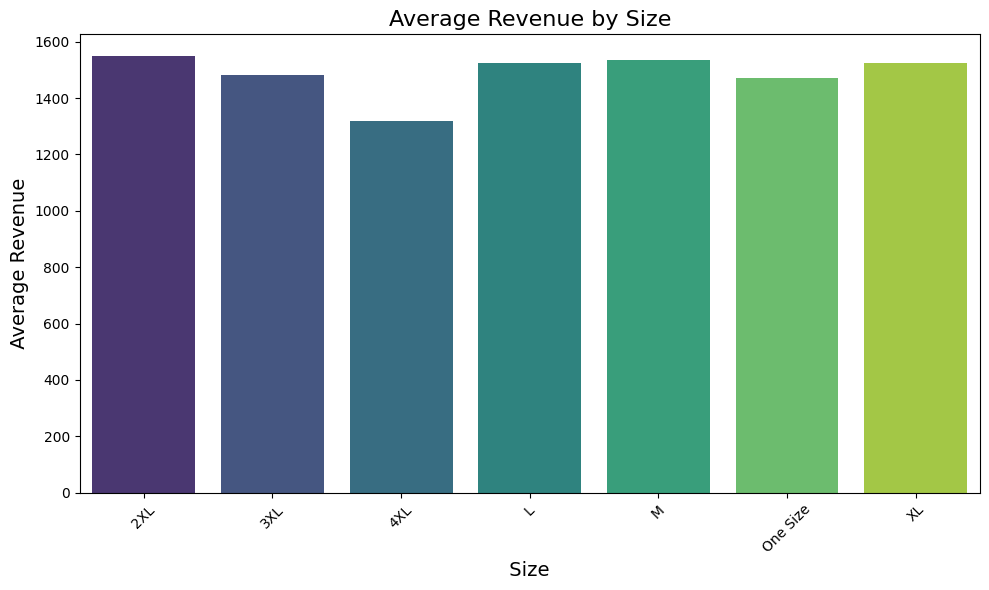

revenue          1.000000
size_M           0.011877
size_XL          0.007976
size_L           0.005695
size_One Size   -0.014548
size_3XL        -0.016670
size_4XL        -0.034360
Name: revenue, dtype: float64


In [ ]:
# Visualization: Bar plot of revenue by size
plt.figure ( figsize=(10, 6))
# Using the size average mean
sns.barplot (x=size_revenue_avg['size'], y=size_revenue_avg['revenue'], palette="viridis")
plt.title ( 'Average Revenue by Size', fontsize=16)
plt.xlabel ( ' Size ', fontsize=14 )
plt.ylabel (' Average Revenue ' , fontsize=14)
plt.xticks ( rotation=45)
plt.tight_layout()
plt.show()

# Correlation analysis (one-hot encode size to compute Pearson correlation)
size_encoded =  pd.get_dummies (df['size'], prefix='size', drop_first=True)
size_encoded['revenue'] =  df['revenue']
correlation_with_revenue =  size_encoded.corr()['revenue'].sort_values(ascending=False)

print(correlation_with_revenue)

<ipython-input-33-7c14233a7688>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot (x=color_revenue_avg['color'], y=color_revenue_avg['revenue'], palette="viridis")


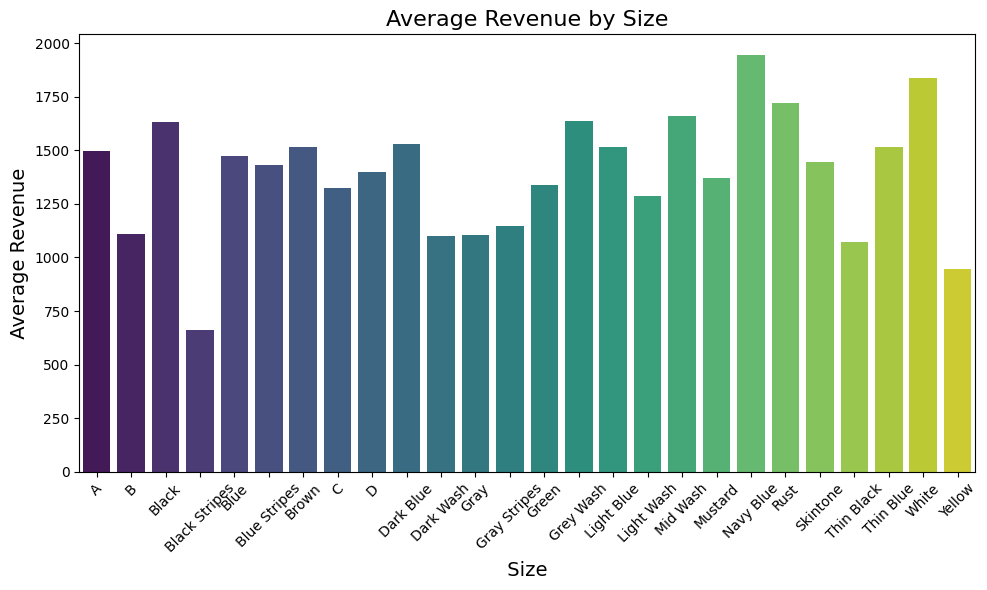

revenue                1.000000
color_Dark Blue        0.033058
color_Navy Blue        0.026567
color_White            0.024481
color_Black            0.023191
color_Mid Wash         0.022729
color_Grey Wash        0.019147
color_Rust             0.015543
color_Thin Blue        0.000351
color_Brown           -0.000058
color_Light Blue      -0.000364
color_Blue            -0.001782
color_Skintone        -0.004787
color_Blue Stripes    -0.007612
color_D               -0.009357
color_Mustard         -0.009881
color_Green           -0.014509
color_Light Wash      -0.015889
color_C               -0.019481
color_Thin Black      -0.027403
color_Gray Stripes    -0.027856
color_Yellow          -0.039424
color_Gray            -0.042204
color_B               -0.045598
color_Black Stripes   -0.045729
color_Dark Wash       -0.051494
Name: revenue, dtype: float64


In [ ]:
# Visualization: Bar plot of revenue by color
plt.figure ( figsize=(10, 6))
# Using the color average mean
sns.barplot (x=color_revenue_avg['color'], y=color_revenue_avg['revenue'], palette="viridis")
plt.title ( 'Average Revenue by Size', fontsize=16)
plt.xlabel ( ' Size ', fontsize=14 )
plt.ylabel (' Average Revenue ' , fontsize=14)
plt.xticks ( rotation=45)
plt.tight_layout()
plt.show()

# Correlation analysis (one-hot encode color to compute Pearson correlation)
color_encoded =  pd.get_dummies (df['color'], prefix='color', drop_first=True)
color_encoded['revenue'] =  df['revenue']
correlation_with_revenue =  color_encoded.corr()['revenue'].sort_values(ascending=False)

print(correlation_with_revenue)

In [ ]:
# Perfoming Tukey's HSD to check the significance in between revenue and size
model = smf.ols('revenue ~ C(size)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df['revenue'], groups=df['size'], alpha=0.05)
print(tukey)

                sum_sq      df         F    PR(>F)
C(size)   2.022265e+06     6.0  0.517776  0.795236
Residual  1.044769e+09  1605.0       NaN       NaN
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1   group2   meandiff p-adj    lower    upper   reject
------------------------------------------------------------
     2XL      3XL  -66.1935 0.9875 -319.1498 186.7629  False
     2XL      4XL -228.3195 0.7765  -694.394  237.755  False
     2XL        L  -23.7257    1.0 -269.2501 221.7987  False
     2XL        M  -13.8635    1.0 -256.0859  228.359  False
     2XL One Size  -79.1011 0.9891 -389.1271 230.9249  False
     2XL       XL    -24.43 0.9999 -249.9955 201.1356  False
     3XL      4XL -162.1261 0.9377 -610.8056 286.5535  False
     3XL        L   42.4678  0.997 -168.1744   253.11  False
     3XL        M     52.33 0.9895  -154.454  259.114  False
     3XL One Size  -12.9076    1.0 -296.1108 270.2956  False
     3XL       XL   41.7635 0.9947 -145.2331 228.7601 

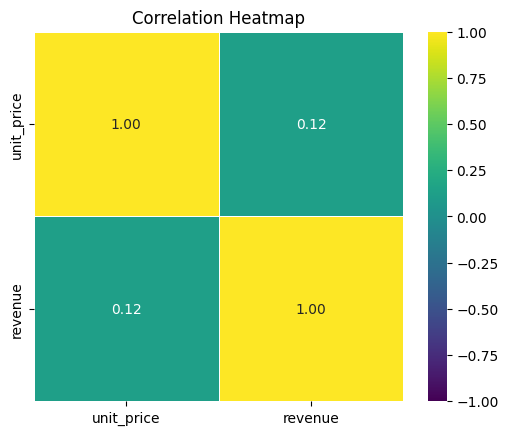

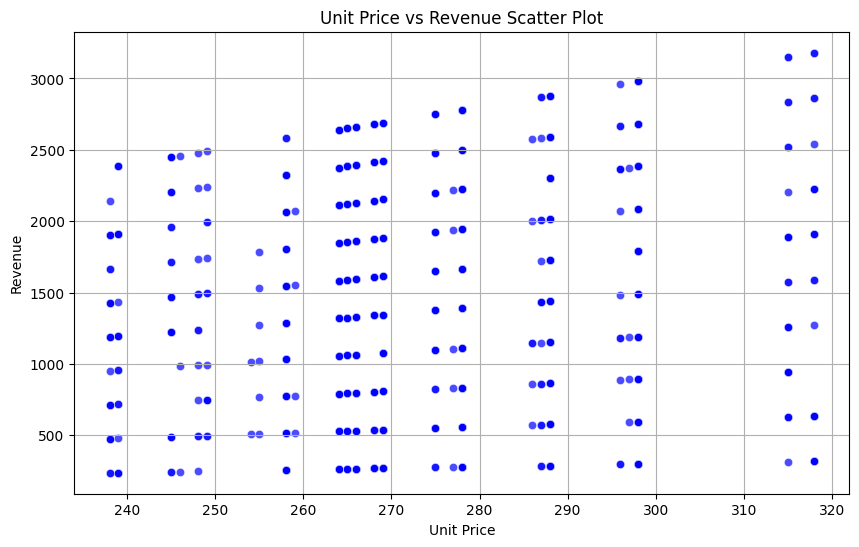

In [ ]:
# Finding the correlation between unit_price and revenue
correlation_matrix = df[['unit_price', 'revenue']].corr()

#using heatmaps
sns.heatmap(correlation_matrix, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


#Scatter plot for unit_price vs revenue
plt.figure (figsize=(10, 6))
sns.scatterplot (data=df, x='unit_price', y='revenue', color='blue', alpha=0.7)
plt.title ("Unit Price vs Revenue Scatter Plot")
plt.xlabel ("Unit Price")
plt.ylabel ("Revenue")
plt.grid (True)
plt.show()

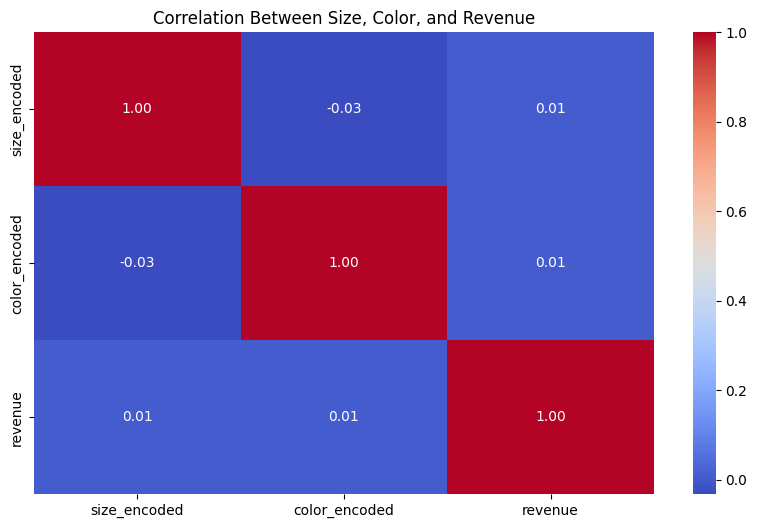

In [ ]:
df['size_encoded'] = df['size'].astype('category').cat.codes
df['color_encoded'] = df['color'].astype('category').cat.codes

# Correlation between size, color, and revenue
size_color_revenue_correlation = df[['size_encoded', 'color_encoded', 'revenue']].corr()

# Visualizing the correlation using a heatmap
plt.figure (figsize=(10,6))
sns.heatmap (size_color_revenue_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title ("Correlation Between Size, Color, and Revenue")
plt.show()



   order_id  revenue  quantity  unit_price          order_date  \
0         1    13962        49  284.666667 2022-06-01 16:05:00   
1         2     4410        18  245.000000 2022-08-30 09:42:00   
2         3    14704        54  272.400000 2022-06-10 19:59:00   
3         4    11744        43  272.000000 2022-06-11 11:42:00   
4         5    17052        63  270.222222 2022-06-11 14:46:00   

   avg_revenue_per_item  
0            284.938776  
1            245.000000  
2            272.296296  
3            273.116279  
4            270.666667  


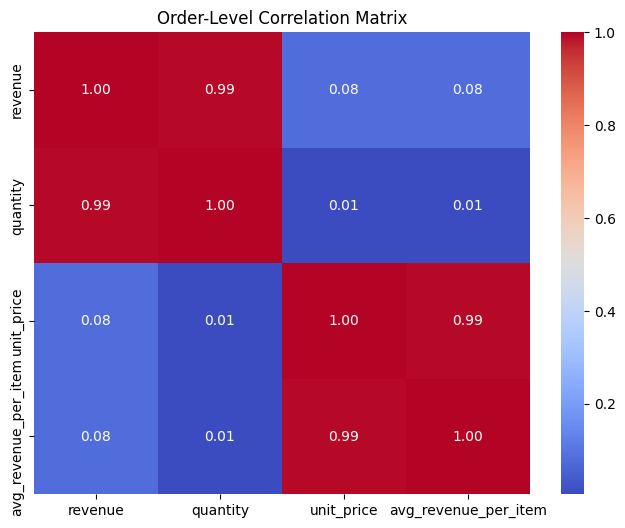

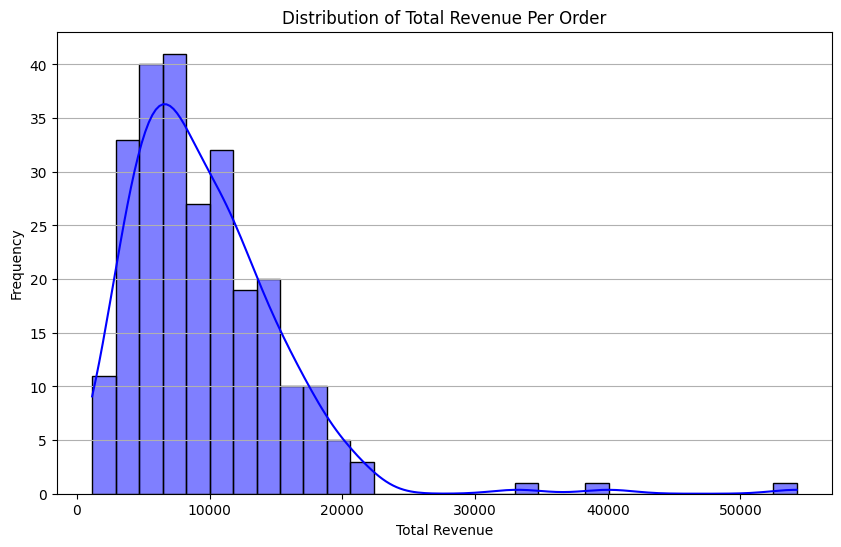

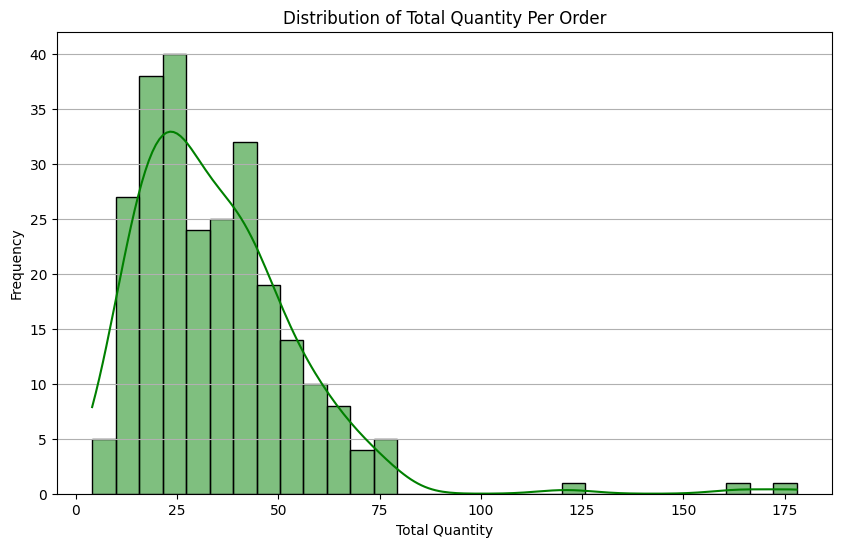

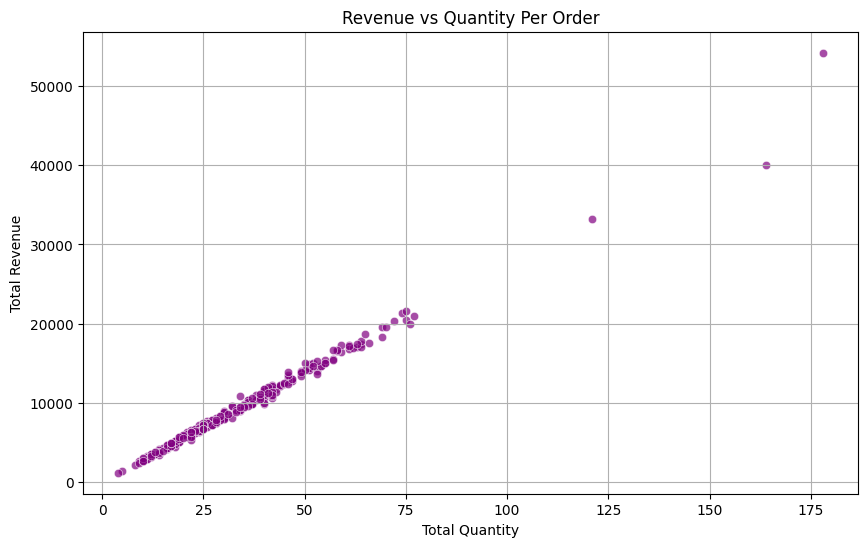

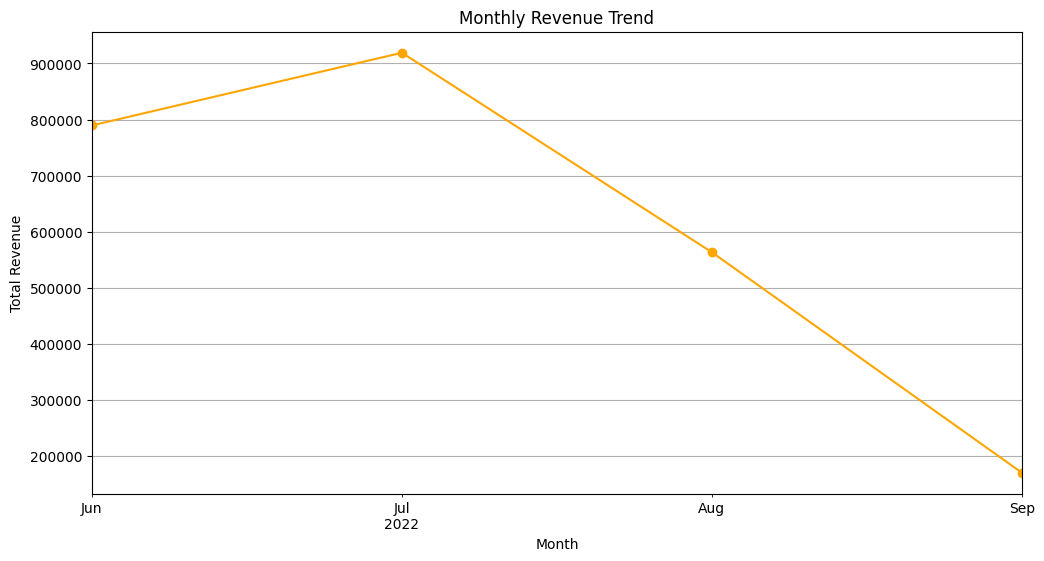

In [ ]:
# 1. Aggregating data at the order level
order_data = df.groupby('order_id').agg({
    'revenue': 'sum',               # Total revenue per order
    'quantity': 'sum',              # Total quantity per order
    'unit_price': 'mean',           # Average unit price per order
    'order_date': 'min'             # Order date (assuming one date per order_id)
}).reset_index()

# Adding  additional metrics like average revenue per item
# Removing extra spaces around the column name
order_data['avg_revenue_per_item'] = order_data['revenue'] / order_data['quantity']

# Displaying  the aggregated order-level data
print (order_data.head())

# 2. Correlation analysis at the order level
# Removing extra spaces around the column name
order_level_correlation  = order_data [['revenue', 'quantity', 'unit_price', 'avg_revenue_per_item']].corr()

# Visualize correlation matrix
plt.figure (figsize = (8, 6) )
sns.heatmap (order_level_correlation, annot=True, cmap='coolwarm', fmt=".2f" )
plt.title ( "Order-Level Correlation Matrix")
plt.show()
# 3. Revenue distribution across orders
plt.figure(figsize = ( 10, 6))
sns.histplot (order_data ['revenue'], bins=30, kde=True, color='blue' )
plt.title ("Distribution of Total Revenue Per Order")
plt.xlabel ("Total Revenue")
plt.ylabel ("Frequency")
plt.grid (axis='y')
plt.show()

# 4. Quantity distribution across orders
plt.figure (figsize = (10, 6))
sns.histplot ( order_data ['quantity'], bins=30 , kde=True, color='green')
plt.title ("Distribution of Total Quantity Per Order")
plt.xlabel ("Total Quantity")
plt.ylabel ("Frequency")
plt.grid (axis='y')
plt.show()

# 5. Analyze revenue vs quantity at the order level
plt.figure(figsize = (10, 6))
sns.scatterplot (data=order_data, x ='quantity', y='revenue', alpha=0.7, color='purple')
plt.title ("Revenue vs Quantity Per Order")
plt.xlabel ("Total Quantity")
plt.ylabel ("Total Revenue")
plt.grid()
plt.show()

# 6. Time-series analysis (if order_date is available)
if 'order_date' in order_data.columns:
    order_data['month'] =order_data['order_date'].dt.to_period('M')
    monthly_revenue =order_data.groupby ('month')['revenue'].sum()
# Plot monthly revenue trend
plt.figure (figsize=(12, 6))
monthly_revenue.plot (kind='line', marker='o', color='orange', title="Monthly Revenue Trend")
plt.xlabel ("Month")
plt.ylabel ("Total Revenue")
plt.grid()
plt.show()


In [ ]:
from scipy.stats import ttest_ind

# Dividing the data into weekdays and weekends
weekends =  df[df['day_of_week'].isin([5, 6])]['revenue']  # Saturday=5, Sunday=6
weekdays =  df[~df['day_of_week'].isin([5, 6])]['revenue']

# Perform the T-test
t_stat, p_value = ttest_ind(weekends, weekdays)
print ( f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Revenue is significantly higher on weekends.")
else:
    print("Fail to reject the null hypothesis: No significant difference in revenue.")

T-Statistic: -0.18995538322485297, P-Value: 0.8493680387747062
Fail to reject the null hypothesis: No significant difference in revenue.


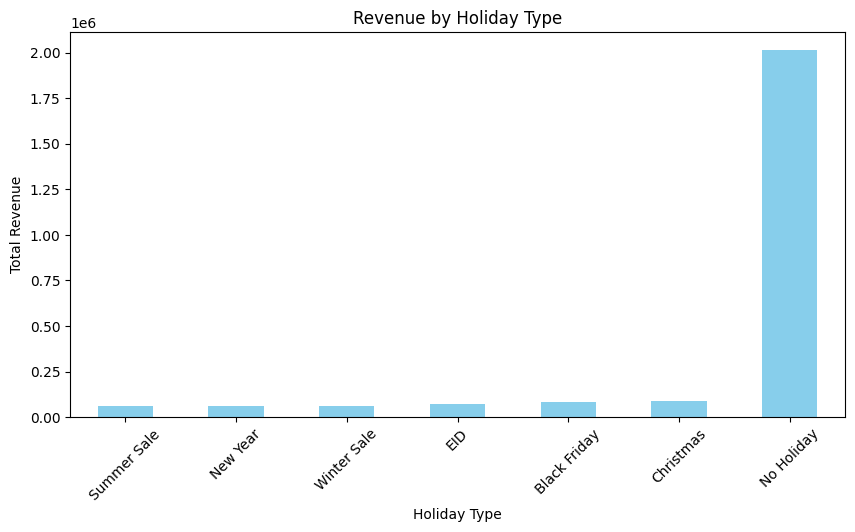

In [ ]:
# Group by Holiday Type and sum revenue
holiday_revenue = df.groupby("holiday_type")["revenue"].sum().sort_values()

# Bar plot
plt.figure(figsize=(10,5))
holiday_revenue.plot(kind='bar', color='skyblue')
plt.xlabel("Holiday Type")
plt.ylabel("Total Revenue")
plt.title("Revenue by Holiday Type")
plt.xticks(rotation=45)
plt.show()

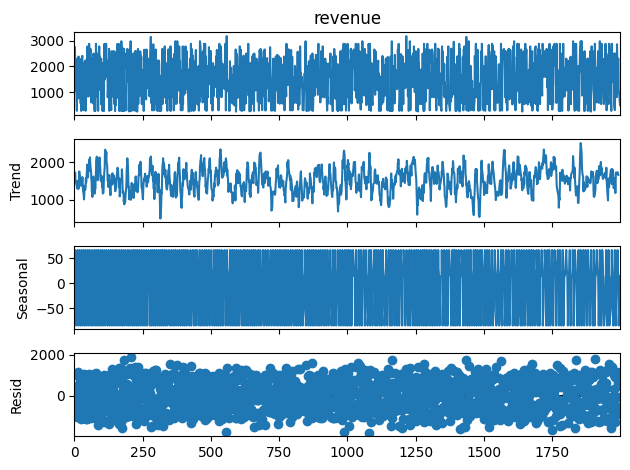

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming the data has a daily frequency, set the period accordingly
# Period value will be adjusted according the dataset
result = seasonal_decompose(df['revenue'], model='additive', period=7)  # Assuming weekly seasonality

result.plot()
plt.show()


In [ ]:
# Convert Date column to datetime format
df['order_date'] = pd.to_datetime(df['order_date'])

# Extract useful date-based features
df['Year'] = df['order_date'].dt.year
df['Month'] = df['order_date'].dt.month
df['Day'] = df['order_date'].dt.day
df['DayOfWeek'] = df['order_date'].dt.dayofweek
df['WeekOfYear'] = df['order_date'].dt.isocalendar().week

# Drop the original datetime column
df.drop(columns=['order_date'], inplace=True)


In [ ]:
# Selecting categorical columns
categorical_cols = ['category', 'color', 'size', 'holiday_type']  # Add any other categorical features

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Splitting into features and target variable
X = df_encoded.drop(columns=['revenue'])
y = df_encoded['revenue']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Print model coefficients
print("Model coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Model coefficients: [ 1.69752931e-02 -1.00838420e-04  5.41733442e+00  2.77603699e+02
  1.47532029e-01 -1.03062846e-01  6.82614980e-01  4.46003685e-03
 -1.64298791e+00  7.41758222e-01  1.64479452e-04 -1.06974477e+00
 -5.68434189e-14 -4.57872635e+00 -3.91196612e-01 -6.47457923e-02
 -2.48689958e-14 -7.34602488e-01 -2.53271528e-01  1.42108547e-14
 -4.57872635e+00 -6.47457923e-02 -3.91196612e-01  1.80982001e+00
 -2.18869538e-01 -2.25256720e+00  6.61890753e-01  8.66906015e-02
  2.42721111e+01  1.60913623e+01  4.82401263e+01  4.10125280e+00
 -9.29695344e+00 -3.96403548e+01 -5.63219132e+01  1.30092454e+01
  9.06427562e+00  3.56837306e+01  6.92207806e+00  1.63061795e+01
 -1.29475153e+01  5.77130155e+00  1.08198491e+01  2.52553394e+01
  5.85742157e+00 -6.24843876e+00  2.08533823e+01 -2.59665992e+01
  4.96878557e+00  1.74335815e+01  2.19354012e+00 -6.73487058e+01
  1.52649608e+01  6.86382770e-01 -3.24641918e+00 -5.55052616e+00
  4.96326842e-01  8.02464201e+00 -3.39751431e+00  4.89210137e+00
  9.7

In [ ]:
feature_names = X_train.columns  # Get feature names
coefficients = model.coef_  # Get coefficients

for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")


order_id: 0.0170
sku: -0.0001
unit_price: 5.4173
quantity: 277.6037
age: 0.1475
discount: -0.1031
customer_rating: 0.6826
stock: 0.0045
category_id: -1.6430
category_avg_price: 0.7418
category_total_revenue: 0.0002
category_popularity: -1.0697
year: -0.0000
month: -4.5787
day_of_week: -0.3912
day: -0.0647
is_holiday: -0.0000
size_encoded: -0.7346
color_encoded: -0.2533
Year: 0.0000
Month: -4.5787
Day: -0.0647
DayOfWeek: -0.3912
WeekOfYear: 1.8098
category_Jackets: -0.2189
category_Jeans: -2.2526
category_Sweaters: 0.6619
category_T-Shirts: 0.0867
color_B: 24.2721
color_Black: 16.0914
color_Black Stripes: 48.2401
color_Blue: 4.1013
color_Blue Stripes: -9.2970
color_Brown: -39.6404
color_C: -56.3219
color_D: 13.0092
color_Dark Blue: 9.0643
color_Dark Wash: 35.6837
color_Gray: 6.9221
color_Gray Stripes: 16.3062
color_Green: -12.9475
color_Grey Wash: 5.7713
color_Light Blue: 10.8198
color_Light Wash: 25.2553
color_Mid Wash: 5.8574
color_Mustard: -6.2484
color_Navy Blue: 20.8534
color_Rust:

In [ ]:
print(X_test.dtypes)

order_id                     int64
sku                         object
unit_price                   int64
quantity                     int64
age                          int64
                             ...  
holiday_type_EID              bool
holiday_type_New Year         bool
holiday_type_No Holiday       bool
holiday_type_Summer Sale      bool
holiday_type_Winter Sale      bool
Length: 65, dtype: object


In [ ]:
X_train = X_train.drop(columns=['sku', 'order_id'], errors='ignore')
X_test = X_test.drop(columns=['sku', 'order_id'], errors='ignore')
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 33.649764839957406
MSE: 2390.453879870434
R² Score: 0.9963329908717111


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid's l1: 4.89158
✅ LightGBM - MAE: 4.8916
✅ LightGBM - MSE: 71.2671
✅ LightGBM - R² Score: 0.999891


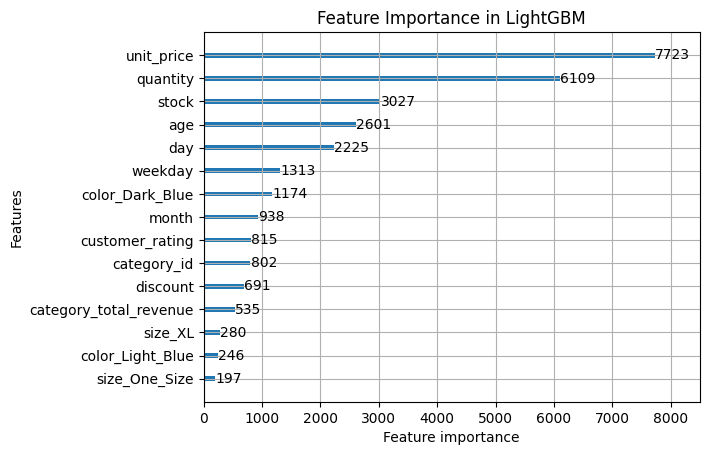

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 🔹 Load dataset
file_path = "/content/Women_Ecommerce_Purchase_Data.csv"
df = pd.read_csv(file_path)

# 🔹 Drop unnecessary columns (order_id and sku are identifiers, not useful for training)
df = df.drop(columns=['order_id', 'sku'])

# 🔹 Convert 'order_date' to datetime and extract useful features
df['order_date'] = pd.to_datetime(df['order_date'])
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day'] = df['order_date'].dt.day
df['weekday'] = df['order_date'].dt.weekday  # Monday = 0, Sunday = 6
df = df.drop(columns=['order_date'])  # Remove raw date column

# 🔹 Convert categorical variables using one-hot encoding
categorical_columns = ['color', 'size', 'category', 'holiday_type']
df = pd.get_dummies(df, columns=categorical_columns)

# 🔹 Define target variable and features
X = df.drop(columns=['revenue'])  # Features
y = df['revenue']  # Target

# 🔹 Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Create LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 🔹 Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1
}

# 🔹 Train LightGBM Model with early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data],
    valid_names=['valid'],
    callbacks=[lgb.early_stopping(50)]
)

# 🔹 Make predictions
y_pred = model.predict(X_test)

# 🔹 Evaluate model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ LightGBM - MAE: {mae:.4f}")
print(f"✅ LightGBM - MSE: {mse:.4f}")
print(f"✅ LightGBM - R² Score: {r2:.6f}")

# 🔹 Feature Importance
lgb.plot_importance(model, max_num_features=15)
plt.title("Feature Importance in LightGBM")
plt.show()



In [ ]:
X.columns = X.columns.str.replace(" ", "_")  # Replace spaces with underscores
# Replace spaces in column names to avoid LightGBM warnings
X.columns = X.columns.str.replace(" ", "_", regex=True)


In [ ]:
!pip install optuna

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "mae",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "verbosity": -1,  # Suppresses logs
    }

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[test_data],  # Validation set
        valid_names=["valid"],
        callbacks=[lgb.log_evaluation(0)] # Remove this line if error persists
    )

    # Make predictions
    y_pred = model.predict(X_test)

    # Return MAE (Optuna minimizes this)
    return mean_absolute_error(y_test, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)



[I 2025-03-28 12:18:28,622] A new study created in memory with name: no-name-38041870-d721-4a76-abd3-7b8e0f8ff854
[I 2025-03-28 12:18:28,892] Trial 0 finished with value: 80.18443465440897 and parameters: {'learning_rate': 0.0705278830169835, 'num_leaves': 246, 'min_data_in_leaf': 173, 'max_depth': 8, 'feature_fraction': 0.5881812465890106, 'bagging_fraction': 0.6983879564575872, 'bagging_freq': 6, 'lambda_l1': 0.8235668570456235, 'lambda_l2': 2.698206771999037e-07}. Best is trial 0 with value: 80.18443465440897.
[I 2025-03-28 12:18:29,168] Trial 1 finished with value: 73.54228325474315 and parameters: {'learning_rate': 0.007481465151051084, 'num_leaves': 230, 'min_data_in_leaf': 167, 'max_depth': 6, 'feature_fraction': 0.8297990737662223, 'bagging_fraction': 0.723064299032719, 'bagging_freq': 10, 'lambda_l1': 2.2599097676437823, 'lambda_l2': 0.005164295430998168}. Best is trial 1 with value: 73.54228325474315.
[I 2025-03-28 12:18:29,516] Trial 2 finished with value: 83.33445684688515 

Best Hyperparameters: {'learning_rate': 0.1519687615596348, 'num_leaves': 100, 'min_data_in_leaf': 30, 'max_depth': 10, 'feature_fraction': 0.9570981136717415, 'bagging_fraction': 0.8524868502850762, 'bagging_freq': 3, 'lambda_l1': 0.06938539739255091, 'lambda_l2': 9.845564696006262e-07}


[100]	valid's l1: 6.52905
[200]	valid's l1: 4.79002
[300]	valid's l1: 4.34384
[400]	valid's l1: 4.05253
[500]	valid's l1: 3.88847
[600]	valid's l1: 3.8198
[700]	valid's l1: 3.74154
[800]	valid's l1: 3.70778
[900]	valid's l1: 3.67403
[1000]	valid's l1: 3.64461
✅ LightGBM - MAE: 3.6446
✅ LightGBM - MSE: 35.9738
✅ LightGBM - R² Score: 0.999945


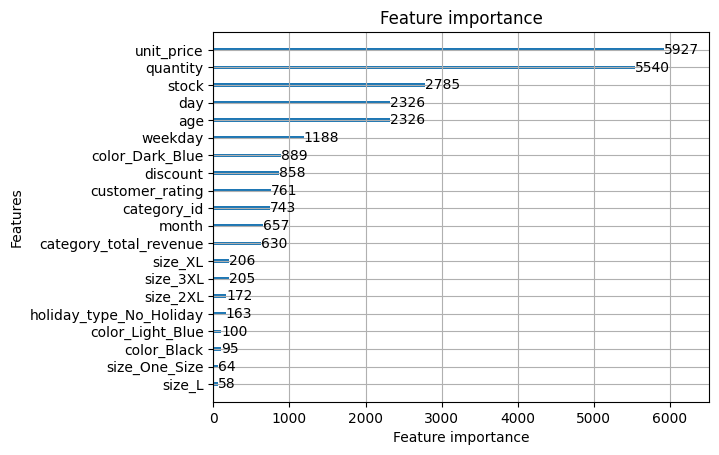

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset (Assume df is already loaded)
# Ensure column names are correct
df.rename(columns={'y': 'revenue'}, inplace=True)

# Handle categorical features
categorical_features = ['size', 'category', 'holiday_type']

# Define input (X) and target variable (y)
X = df.drop(columns=['revenue'])  # Revenue is the target
y = df['revenue']

# Split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure same features in training and validation sets
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_valid.fillna(0, inplace=True)  # Fill missing values if necessary

# Best LightGBM parameters (based on your previous tuning)
best_params = {
    "objective": "regression",
    "metric": "mae",
    "boosting_type": "gbdt",
    "learning_rate": 0.0585,
    "num_leaves": 120,
    "min_data_in_leaf": 28,
    "max_depth": 10,
    "feature_fraction": 0.99,
    "bagging_fraction": 0.93,
    "bagging_freq": 3,
    "lambda_l1": 0.000265,
    "lambda_l2": 0.00311,
    "verbosity": -1
}

# Convert data into LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Train the LightGBM model
final_model = lgb.train(
    best_params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data],
    valid_names=["valid"],
    callbacks=[lgb.log_evaluation(100)]  # Log every 100 rounds
)

# Make final predictions
y_pred = final_model.predict(X_valid)

# 🔹 Evaluate model
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"✅ LightGBM - MAE: {mae:.4f}")
print(f"✅ LightGBM - MSE: {mse:.4f}")
print(f"✅ LightGBM - R² Score: {r2:.6f}")

lgb.plot_importance(final_model, max_num_features=20)
plt.show()


In [ ]:
final_model.save_model("lightgbm_model.txt")


In [ ]:
# The model is trained now, only thing to do is just load the model and give new dataset as its input

loaded_model = lgb.Booster(model_file="lightgbm_model.txt")
y_pred = loaded_model.predict(X_test)


In [ ]:
from prophet import Prophet
import pandas as pd

# Load dataset (ensure your dataset has 'ds' and 'y' columns)
df = pd.read_csv("/content/Women_Ecommerce_Purchase_Data.csv")
df=df.rename(columns={'order_date':'ds','revenue':'y'})

# Ensure the date column is in the correct format
df['ds'] = pd.to_datetime(df['ds'])

# Initialize and fit Prophet model
prophet = Prophet()
prophet.fit(df[['ds', 'y']])  # 'y' should be the column representing sales/revenue

# Create a future dataframe for forecasting
future = prophet.make_future_dataframe(periods=30)  # Change periods as needed

# Get forecast
forecast = prophet.predict(future)

# Extract the relevant prediction values
forecast = forecast[['ds', 'yhat']]

# Rename yhat (forecasted values) for merging with LightGBM dataset
forecast.rename(columns={'yhat': 'prophet_forecast'}, inplace=True)

# Merge Prophet results with your dataset (on date column)
df = df.merge(forecast, on='ds', how='left')

# Save the new dataset with Prophet results
df.to_csv("dataset_with_prophet.csv", index=False)

print("Prophet results added to dataset.")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv4mda2f9/khg7lwb0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv4mda2f9/1x75nllv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55175', 'data', 'file=/tmp/tmpv4mda2f9/khg7lwb0.json', 'init=/tmp/tmpv4mda2f9/1x75nllv.json', 'output', 'file=/tmp/tmpv4mda2f9/prophet_modelux4xkpr7/prophet_model-20250328114736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:47:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet results added to dataset.
